In [ ]:
import json
import shutil
import xml.etree.ElementTree as ET
from urllib.parse import urlparse, parse_qs, urlunparse
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

df = pd.DataFrame()

baseUrl = "https://buy.yungching.com.tw"
queryUrl = "/region/%E4%BD%8F%E5%AE%85_p/%E5%8F%B0%E5%8C%97%E5%B8%82-%E5%A3%AB%E6%9E%97%E5%8D%80_c/_rm/%E7%84%A1%E9%9B%BB%E6%A2%AF%E5%85%AC%E5%AF%93_type/n_park/"

# 網站有擋爬蟲 要加headers假裝我們是真的使用者登入網站
pagesReq = Request(
    url=baseUrl + queryUrl,
    headers={'User-Agent': 'Mozilla/5.0'}
)

# 把整個網頁讀下來
pagesWebpage = urlopen(pagesReq).read()
# 可以把註解拿掉看print出來長怎樣
# print(webpage)
# 把 webpage 印出來會長跟這個網址內容一樣（view-source也要複製去查）


# 跟電腦說這段扒下來的資料是HTML格式 這樣我們才可以直接用find去做爬蟲
pagesSoup = BeautifulSoup(pagesWebpage, 'html.parser')
# print(pagesSoup)

# #有很多頁所以要每一頁都點進去

pageNum = pagesSoup.find('a', class_='ga_click_trace', string="最末頁").get('href').replace(queryUrl+"?pg=", "")
print("有" + pageNum + "頁\n\n")

## 把這邊改掉就可以指定頁數
## 如果只要第六頁
## for i in range(6,7):
for i in range(1, int(pageNum)+1):
  fullUrl = baseUrl + queryUrl + "?pg=" + str(i)
  req = Request(
    url=fullUrl,
    headers={'User-Agent': 'Mozilla/5.0'}
  )
  webpage = urlopen(req).read()
  soup = BeautifulSoup(webpage, 'html.parser')
  print("進入第" + str(i) + "頁\n\n")


  # 看剛剛view-source那個網站對比原本網站的樣子
  # 可以發現<li class="m-list-item">這個標籤包括了一整組房屋資訊
  liList = soup.find_all('li', class_='m-list-item')
  # print(liList)

  #針對每一組房屋資訊i
  for i in liList:
    # 去觀察他的view-source （截圖在下一格）
    # 物件編號和捷運站距離 在最外面的資訊欄沒有 所以要先截取他的連結 點進去之後再取
    moreInfo = i.find('a', class_="item-title ga_click_trace").get('href')
    moreInfoReq = Request(
      url=baseUrl + moreInfo,
      headers={'User-Agent': 'Mozilla/5.0'}
    )
    moreInfoWebpage = urlopen(moreInfoReq).read()
    moreInfoSoup = BeautifulSoup(moreInfoWebpage, 'html.parser')

    # 屋名都放在h3裡面 而且通常只有一個h3 所以直接用find就好
    name = i.find('h3')
    # print(name)
    # find出來的東西 他的格式是tag(HTML標籤的意思) 所以要加上.text不然會連前後標籤（<h3>之類的）都印出來
    # print('屋名：' + name.text)

    # 1) 「永慶房屋物件編號」(例如 YC1084750) house-info-addr
    addr = moreInfoSoup.find('div', class_="house-info-addr")
    num = moreInfoSoup.find('div', class_="house-info-num")
    # print('永慶房屋物件編號：' + num.text)

    # 2) 「售價」(以萬為單位)
    # 觀察HTML 價格都放在<div class="price">裡面 而且只出現一次 直接find就好
    price = i.find('div', class_="price")
    # print('售價：' + price.text)

    # 建物面積、屋齡、房(室)都放在li裡面 而且沒有其他class之類的可以輔助尋找
    # 所以要來找規律 幾乎每一組的第一個（item[0]）都是住宅類型（EX華廈）、第二個是年分、第三個樓層、第四個土地坪數...以此類推
    # find_all抓出來的東西會存在一個list裡面 想要抓list是從0開始算 （第一個是0第二個是1以此類推）
    item = i.find_all('li')
    # 3) 「建物面積」(坪數)
    # print('建物面積：' + item[5].text)
    # 4) 「屋齡」(年)
    # print('屋齡：' + item[1].text)
    # 5) 「房(室)」數
    # print('房(室)：' + item[6].text)

    # 6) 「物件與最近捷運站(已正式營運)的距離」(公尺)
    commuteTable = moreInfoSoup.find('table', class_="map-locations-table poiTraffic is-active")
    # print(commuteTable)
    #table底下 第一組tr會是標題 第二組通常是捷運+最近的捷運站 裡面的第三個td就是距離
    station = "NONE"
    dis = "NONE"
    isMetro = commuteTable.find('td', class_="tbl-locations-type", string="捷運")
    metroNum = 1
    if(isMetro == None):
      station = "沒有捷運站"
    else:
      # 不只有一個捷運站
      if(isMetro.get("rowspan") != None):
        metroNum = int(isMetro.get("rowspan"))
      metro = commuteTable.find_all('td', class_="tbl-locations-name")
      for i in metro[0:metroNum]:
        if (dis == "NONE"):
          # 還有(未通車)
          # 有捷運站 又不是規劃中 => 抓距離
          station = '規劃中或未通車'
          if not (("規劃中" in i.text) | ("未通車" in i.text)):
              station = i.text
              dis = i.next_sibling.next_sibling.text
              #dis = dis.split(", ")[0]
              dis = dis.split("公尺")[0]
              dis = dis.replace("約","")
        else:
          break

    # print('最近捷運站：' + station)
    # print('與捷運站距離：' + dis)

    # print('\n')

    data = [[name.text, addr.text, num.text, price.text, item[5].text, item[1].text.replace("\r\n", ""), item[6].text.replace("\r\n", ""), station, dis.replace("\r\n", "")]]
    df = df.append(data)

df.columns=['屋名', '地址', '1)永慶房屋物件編號', '2)售價', '3)建物面積', '4)屋齡', '5)房(室)', '站名','6)物件與最近捷運站(已正式營運)的距離']

df.to_csv('/content/drive/MyDrive/Colab Notebooks/YCfile.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
有5頁


進入第1頁




<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: Futu

進入第2頁




<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: Futu

進入第3頁




<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: Futu

進入第4頁




<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: Futu

進入第5頁




<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
<ipython-input-4-6811f88787f3>:132: Futu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


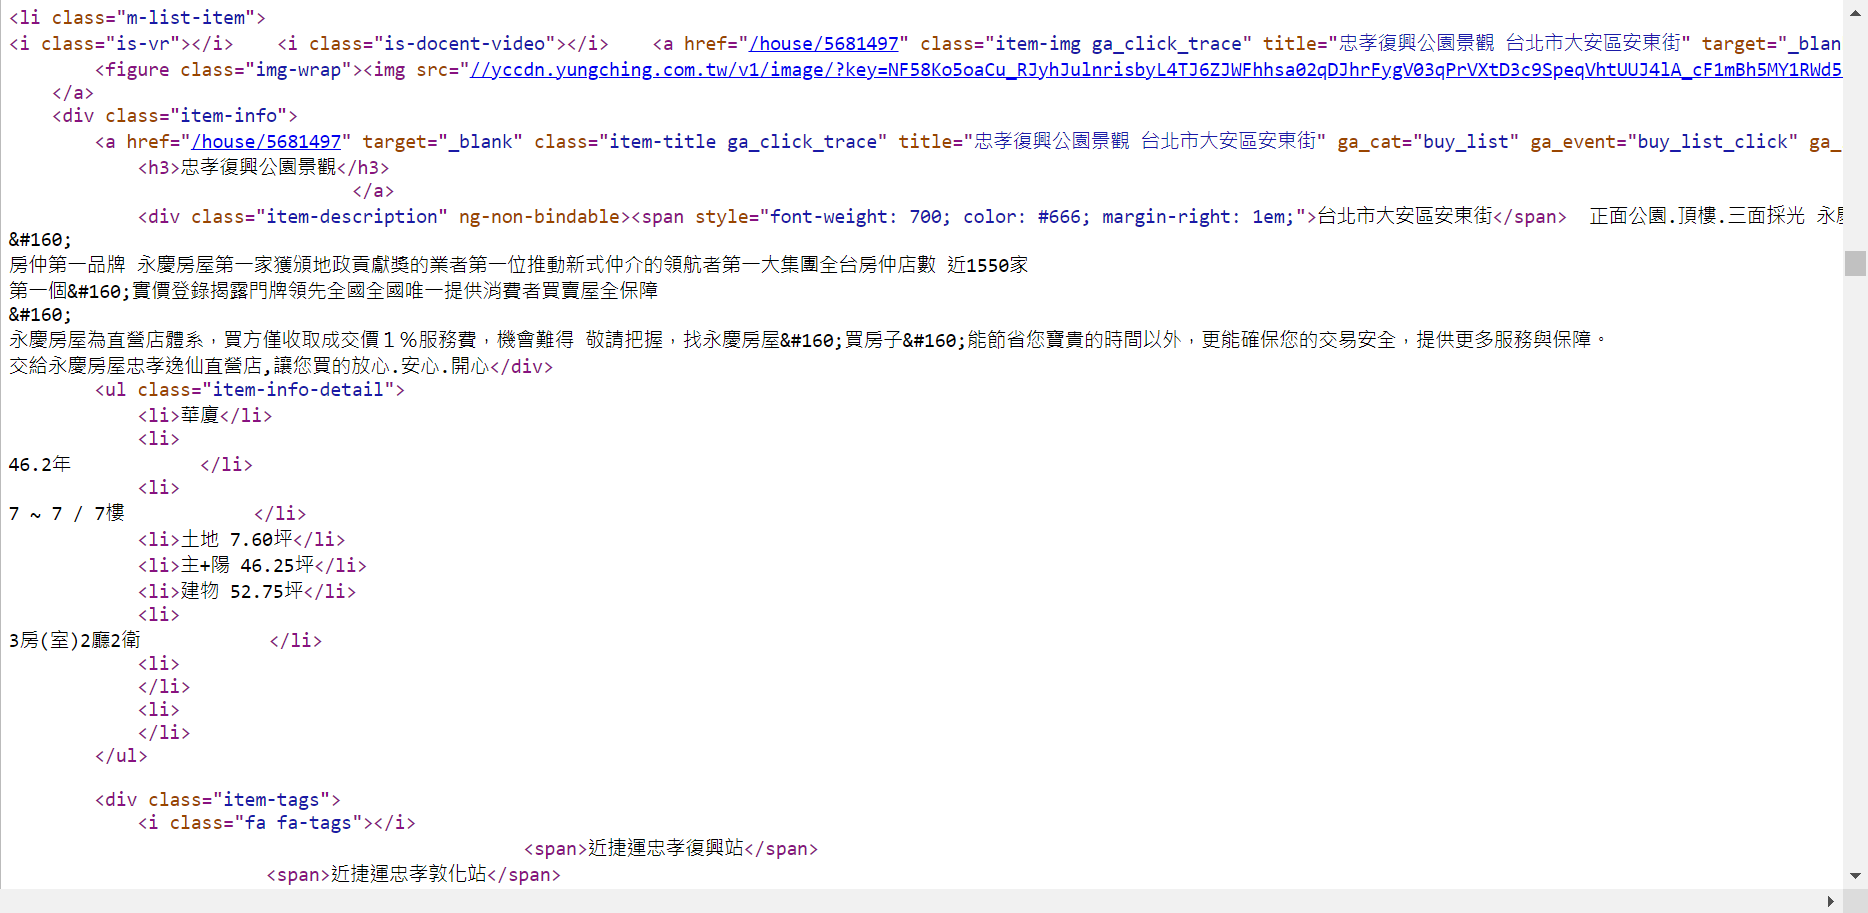